In [1]:
import os
os.chdir(os.path.join(os.pardir, os.pardir))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

#Styling Block
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 26
FIG_SIZE = (12,6) #change figure size throughout for non-faceted figures
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style('white')
cp = sns.color_palette() #color palette to use throughout 

In [2]:
country = 'india'
scenario = 'base'
results_path = os.path.join('runs', 'results_20201130_165715')

results = pd.read_csv(os.path.join(results_path,'india_base','agent_outputs.csv'))
results.rename({'metric_value':'payback_period'}, axis='columns', inplace=True)
results.head()

,agent_id,state_name,sector_abbr,geo_sector_n_agents,owner_occupancy_status,developable_buildings_pct,cap_cost_multiplier,district_name,developable_roof_sqft,load_per_customer_in_bin_kwh_initial,...,new_batt_kw,new_batt_kwh,number_of_adopters,market_value,pv_kw_cum,batt_kw_cum,batt_kwh_cum,total_gen_twh,index,max_market_share_last_year
0,0,haryana,res,581,1,1,1,palwal,247.485089,509.861986,...,0.0,0.0,0.500628,1822.237485,1.025718,0.0,0.0,0.002067,0,NaN
1,1,haryana,res,581,1,1,1,palwal,272.726897,554.777775,...,0.0,0.0,1.182403,4303.829568,2.422581,0.0,0.0,0.004881,1,NaN
2,2,haryana,res,581,1,1,1,palwal,14.933000,644.609354,...,0.0,0.0,4.512043,16423.395026,9.244557,0.0,0.0,0.018626,2,NaN
3,3,haryana,res,581,1,1,1,palwal,163.385787,1240.991227,...,0.0,0.0,0.659730,2401.353164,1.351697,0.0,0.0,0.002723,3,NaN
4,4,haryana,res,581,1,1,1,palwal,107.915673,287.778359,...,0.0,0.0,0.002556,9.303063,0.005237,0.0,0.0,0.000011,4,NaN


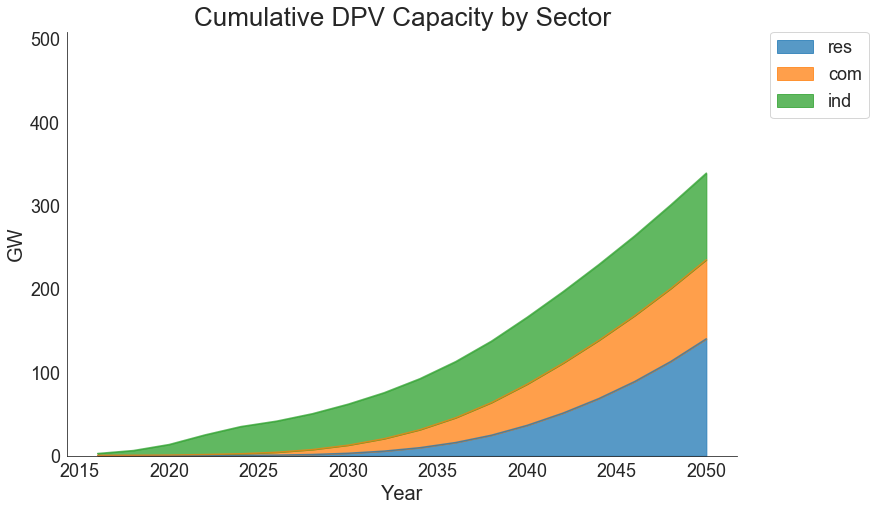

In [3]:
data = results.copy()
data['pv_GW_cum'] = data['pv_kw_cum'] / 1e6
deployment = data.groupby(['year','sector_abbr'])['pv_GW_cum'].sum().reset_index()
deployment = deployment.pivot(index='year', columns='sector_abbr', values='pv_GW_cum')

df = deployment[['res','com','ind']]

fig, ax = plt.subplots(figsize=(FIG_SIZE[0], FIG_SIZE[1]*1.3))
df.plot.area(ax=ax, alpha=0.75)

# --- Readjust ylim ---
ax.set_ylim((0, max(list(deployment.sum(axis=1))) * 1.5))

ax.set_title(f'Cumulative DPV Capacity by Sector')
ax.set_ylabel('GW')
ax.set_xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(fig)

Text(0.5, 0, 'Payback Period')

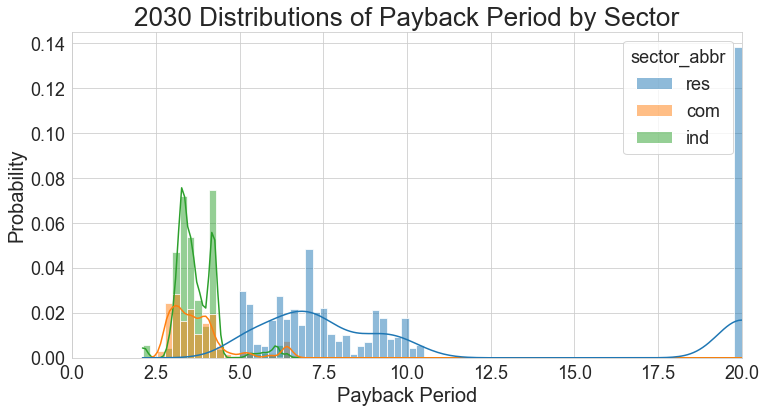

In [4]:
# --- HISTOGRAM OF PAYBACK IN 2030---
sns.set_style('whitegrid')

data_2030 = results.loc[results['year'] == 2030]

fig, ax = plt.subplots(figsize=FIG_SIZE)
sns.histplot(data_2030, x="payback_period", hue='sector_abbr', stat='probability', kde=True, ax=ax)

ax.set_xlim(0,20)
ax.set_title('2030 Distributions of Payback Period by Sector')
ax.set_xlabel('Payback Period')

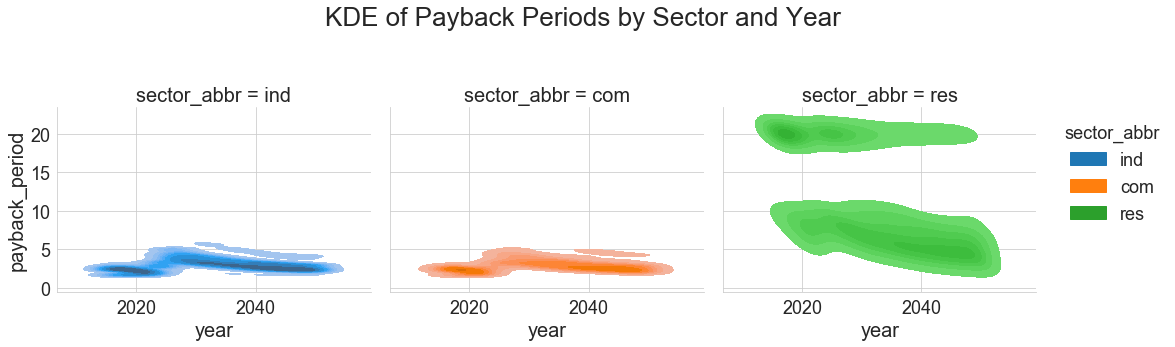

In [5]:
# --- KDE PLOT OF PAYBACK PERIODS BY YEAR ---
g = sns.displot(
    data=results.sample(50000),
    x='year', y='payback_period',
    col='sector_abbr', hue='sector_abbr',
    kind='kde', fill=True
)

g.fig.suptitle('KDE of Payback Periods by Sector and Year')
g.fig.subplots_adjust(top=.7)

In [6]:
results.loc[results['state_name']=='karnataka']\
    .groupby(['year'])['pv_kw_cum'].sum() / 1000

year
2016      192.252030
2018      402.076614
2020      856.456891
2022     1653.929807
2024     2443.388066
2026     2710.587947
2028     3243.897499
2030     4091.572989
2032     5294.167638
2034     6937.711616
2036     8963.534796
2038    11284.409204
2040    13865.889360
2042    16583.141162
2044    19281.194368
2046    21783.660048
2048    24012.708936
2050    25791.543519
Name: pv_kw_cum, dtype: float64

In [7]:
# --- PIVOT of ADOPTION BY DISTRICT AND SECTOR ---
pivot = results.pivot_table(
    index=['state_name','district_name','sector_abbr'],
    columns='year',
    values='pv_kw_cum',
    aggfunc='sum',
    margins=True
)

pivot = pivot / 1000 #kW to MW
pivot.reset_index(inplace=True)
pivot.drop('All', axis='columns', inplace=True)

pivot.to_csv(f"{results_path}_dpv_MW_cum.csv")
pivot.head()

year,state_name,district_name,sector_abbr,2016,2018,2020,2022,2024,2026,2028,...,2032,2034,2036,2038,2040,2042,2044,2046,2048,2050
0,andaman_nicobar_islands,nicobars,com,0.000750,0.002065,0.004404,0.008464,0.015311,0.026829,0.046521,...,0.134796,0.223700,0.361710,0.562940,0.836850,1.163738,1.513464,1.846457,2.115826,2.310951
1,andaman_nicobar_islands,nicobars,ind,0.000871,0.002852,0.007332,0.017194,0.038268,0.079503,0.151763,...,0.372070,0.470385,0.542658,0.592750,0.629351,0.647071,0.655261,0.658965,0.660623,0.661363
2,andaman_nicobar_islands,nicobars,res,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.017991,0.046965,0.093310,0.165913,0.276977,0.441128,0.672322,0.974559
3,andaman_nicobar_islands,north_middle_andaman,com,0.002583,0.007112,0.015164,0.029142,0.052704,0.092339,0.160064,...,0.463664,0.769436,1.243863,1.935618,2.876494,3.999347,5.200650,6.344475,7.269750,7.940001
4,andaman_nicobar_islands,north_middle_andaman,ind,0.003366,0.011024,0.028278,0.066252,0.146948,0.304841,0.579809,...,1.415402,1.787204,2.058846,2.247119,2.383853,2.450050,2.480646,2.494483,2.500679,2.503442


In [55]:
pivot.sum()

year
state_name       andaman_nicobar_islandsandaman_nicobar_islands...
district_name    nicobarsnicobarsnicobarsnorth_middle_andamanno...
sector_abbr      comindrescomindrescomindrescomindrescomindresc...
2016                                                        5476.9
2018                                                       12613.5
2020                                                       27083.5
2022                                                       50103.3
2024                                                       70043.3
2026                                                       83123.1
2028                                                        100933
2030                                                        123850
2032                                                        151149
2034                                                        184781
2036                                                        225822
2038                                                     

In [41]:
scenario_folder = os.path.join('input_scenarios',f"{country}_{scenario}")

# --- load by sector ---
load_profile = pd.read_json(os.path.join(scenario_folder, 'normalized_load.json'))

# --- cumulative load by year / sector ---
merged = results.groupby(['state_id','state_name','district_id','district_name','sector_abbr','year'], as_index=False)[['load_in_bin_kwh', 'pv_kw_cum','tilt']].sum()

# --- denormalize load ---
merged = merged.merge(load_profile, on='sector_abbr')
denormalize = lambda x: np.array(x['kwh']) * (x['load_in_bin_kwh'] / sum(x['kwh']))
merged['kwh_denormed'] = merged.apply(denormalize, axis=1)

# # --- load solar by district ---
descale = lambda x: np.array(x) / 1e3
solar_cf = pd.read_json(os.path.join(scenario_folder, 'solar_resource_hourly.json'))
solar_cf['cf'] = solar_cf['cf'].apply(descale)
merged = merged.merge(solar_cf, on=['district_id'])

# --- calculate generation by district ---
scale_solar = lambda x: np.array(x['cf']) * np.array(x['pv_kw_cum'])
merged['solar_gen'] = merged.apply(scale_solar, axis=1)

# # --- calculate net load by district ---
calc_net_load = lambda x: ((x['kwh_denormed'] - x['solar_gen'])).round(0).astype(np.int32)
merged['net_load_profile'] = merged.apply(calc_net_load, axis=1)

# --- iteratively combine districts with multiple sectors ---
unique_dicts = merged[['state_name','district_name','year']].drop_duplicates().to_dict('records')
for index, d in enumerate(unique_dicts):
    state_mask = (merged['state_name'] == d['state_name'])
    district_mask = (merged['district_name'] == d['district_name'])
    year_mask = (merged['year'] == d['year'])
    subset = merged.loc[state_mask & district_mask & year_mask]
    profiles = list(subset['net_load_profile'])
    cum_net_load = np.sum(profiles, axis=0)
    unique_dicts[index]['net_load_kwh_8760'] = cum_net_load
    unique_dicts[index]['net_load_kwh_cum'] = cum_net_load.sum()
    unique_dicts[index]['pv_kw_cum'] = subset['pv_kw_cum'].sum()
    
net_load = pd.DataFrame(unique_dicts)
net_load.to_json(f"{results_path}_dpv_net_load.json")
# net_load.head()

len(set(merged['district_name']))


634

In [94]:
import importlib
import india.helper as helper
importlib.reload(helper)
import geopandas as gpd

def merge_district_geometry(agents):
    # --- load district shapefile ---
    districts = gpd.read_file(os.path.join('india','reference_data','districts_shapefile', 'India_Districts_ADM2_GADM.shp'))
    districts = districts[['NAME_1','NAME_2','VARNAME_2','geometry']]
    districts.columns = ['state_name','district_name','var_district_name','geometry']
    
    # --- clean state and district columns ---
    districts['state_name'] = districts['state_name'].apply(helper.sanitize_string)
    districts['district_name'] = districts['district_name'].apply(helper.sanitize_string)
    
    # --- create fuzzy list for string matching ---
    agents['fuzzy_str'] = agents['state_name'] + '_' + agents['district_name']
    
    # --- create clean list for string matchibng ---
    districts['clean_str'] = districts['state_name'] + '_' + districts['district_name']
    districts = districts.drop_duplicates(subset=['clean_str'])
    
    # --- fuzzy string matching ---
    agents['clean_str'] = helper.fuzzy_address_matcher(agents['fuzzy_str'], districts['clean_str'])
    
    # --- merge geometry onto agents ---
    agents = agents.merge(districts[['clean_str','geometry']], on='clean_str', how='left')
    agents.drop(['clean_str','fuzzy_str'], axis='columns')
    
    return agents

net_load['pv_MW_cum'] = net_load['pv_kw_cum'] / 1e3
gdf = merge_district_geometry(net_load)
gdf = gpd.GeoDataFrame(gdf)
gdf.head()

NotImplementedError: fillna currently only supports filling with a scalar geometry

In [124]:
# --- libraries ---
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import shapely
import sklearn
from matplotlib import rcParams
import imageio

def feeder_choropleth(df, year=2050,
                      column='pv_MW_cum',
                      **kwargs):
    
    # --- subset year ---
    assert year in set(df['year'])
    ydf = df.loc[df['year'] == year]
    
    # --- Initialize crs ---
    stamen_background = cimgt.Stamen('terrain-background')
    crs = stamen_background.crs
#     crs = ccrs.LambertConformal()
    ydf.crs = 'EPSG:4326'
    ydf = ydf.to_crs(crs.proj4_init)
    bounds = ydf.total_bounds
    bounds = [bounds[0], bounds[2], bounds[1], bounds[3]]
    
    # --- Initialize Figure ---
    fig = plt.figure(dpi=220)
    ax = fig.add_axes([0, 0, 1, 1], projection=crs)
    ax.set_extent(bounds, crs)
    
    # --- Add tiles ---
    ax.add_image(stamen_background, 5)

    # --- plot ---
    ydf.plot(column=column, ax=ax, alpha=0.9, \
             cmap='YlOrRd', legend=True, \
             legend_kwds={'shrink':0.75, 'alpha':0.9,'label':'MW'},
#              scheme='quantiles',
             edgecolor='k', linewidth=0.25,
            **kwargs)
    
    # --- Clean up ---
    ax.set_title(f"{year} DPV Adoption by District", size=12)
    
    # --- Cumulative Curve ---
    cum = df.loc[df['year'] <= year]
    cum = cum.groupby(['year'], as_index=False)[column].sum()
    a = plt.axes([.6, .29, .17, .13])
    plt.plot(cum['year'], cum[column]/1000, color='orange')
    plt.title('Cumulative GW', size=7)
    plt.xlim((df['year'].min(), df['year'].max()))
    plt.tick_params(labelsize=5)
    plt.ylim((0, 400))
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    
    # --- Cumulative Hist ---
    a = plt.axes([.6, .07, .17, .13])
    plt.hist(ydf[column], range=(0,1200), color='orange', bins=20)
    plt.title('Distribution', size=7)
    plt.tick_params(labelsize=5)
    plt.xlabel('MW in District', size=5)
    plt.ylabel('# of Districts', size=5)
    plt.ylim(0,500)
#     a.spines['right'].set_visible(False)
#     a.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join('india','district_choropleths',f'{scenario}_{year}.png'), bbox_inches="tight")
    plt.close()
    return fig
 
def make_gif(scenario):
    files = os.listdir(os.path.join('india','district_choropleths'))
    files = [f for f in files if scenario in f]
    files = [f for f in files if '.png' in f]
    files.sort()
    
    # --- make last image the first image, so it's the preview ---
    files.insert(0, files.pop())

    images = []
    for filename in files:
        images.append(imageio.imread(os.path.join('india','district_choropleths',filename)))
    imageio.mimsave(os.path.join('india','district_choropleths',f'{scenario}.gif'), images, fps=2.5)
    


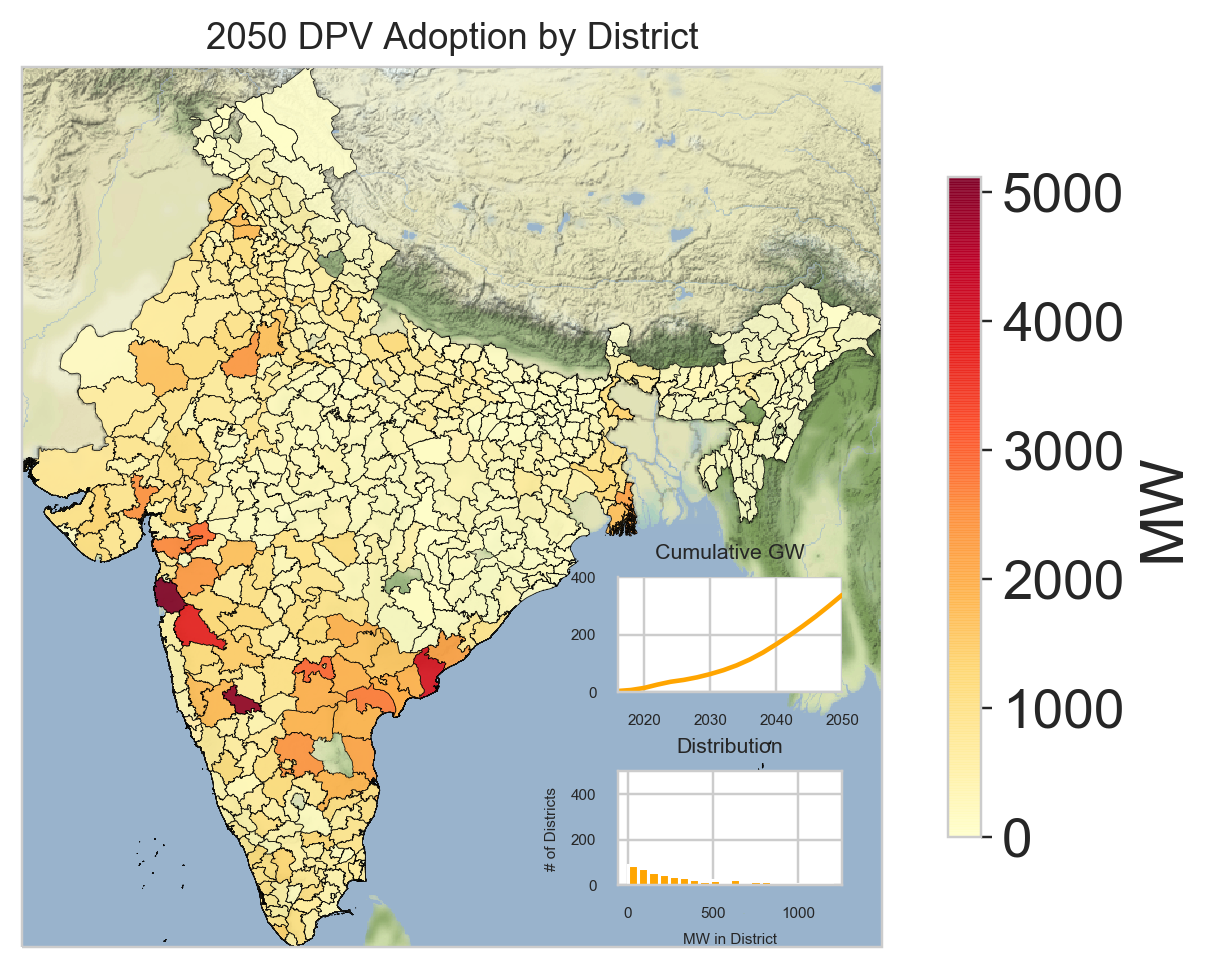

In [125]:
vmax = gdf['pv_MW_cum'].max()
feeder_choropleth(gdf, year=2050, vmin=0, vmax=vmax)

In [122]:
vmax = gdf['pv_MW_cum'].max()
for y in range(2016,2051,2):
    feeder_choropleth(gdf, y, vmax=vmax)
        
make_gif(scenario)

In [104]:
net_load.to_pickle(f"{results_path}_dpv_net_load.pkl")

In [126]:
set(net_load['district_name'])

{'adilabad',
 'agra',
 'ahmadabad',
 'ahmadnagar',
 'aizawl',
 'ajmer',
 'akola',
 'alappuzha',
 'aligarh',
 'alirajpur',
 'allahabad',
 'almora\n',
 'alwar',
 'ambala',
 'ambedkar_nagar',
 'amravati',
 'amreli',
 'amritsar',
 'anand',
 'anantapur',
 'anantnag',
 'anjaw',
 'anugul',
 'anuppur',
 'araria',
 'ariyalur',
 'arwal',
 'ashoknagar',
 'auraiya',
 'aurangabad',
 'azamgarh',
 'badgam',
 'bagalkot',
 'bageshwar',
 'baghpat',
 'bahraich',
 'baksa',
 'balaghat',
 'balangir',
 'baleshwar',
 'ballia',
 'balrampur',
 'banas_kantha',
 'banda',
 'bandipore',
 'bangalore',
 'bangalore_rural',
 'banka',
 'bankura',
 'banswara',
 'bara_banki',
 'baramula',
 'baran',
 'barddhaman',
 'bareilly',
 'bargarh',
 'barmer',
 'barnala',
 'barpeta',
 'barwani',
 'bastar',
 'basti',
 'bathinda',
 'baudh',
 'begusarai',
 'belgaum',
 'bellary',
 'betul',
 'bhadrak',
 'bhagalpur',
 'bhandara',
 'bharatpur',
 'bharuch',
 'bhavnagar',
 'bhilwara',
 'bhind',
 'bhiwani',
 'bhojpur',
 'bhopal',
 'bid',
 'bid